# Are young people really too lazy to buy homes?

Recently, there has been a discourse in the United States regarding the status of the housing market. According to the Population Reference Bureau (PRB), the amount of people ages 20-34 who own homes has dropped from 44% to 34% since 1960 through 2017. In that same span of time however, the amount of people ages 65+ who own homes has grown from 69% to 78%. While there can be a lot of contributing factors to this, I believe that capitalism in the United States has gradually helped older people more and more at the expense of younger people, and that younger people can work just as hard and not make as much money. 

# Step 1: Data Wrangling

Here, I will be importing a csv file containing data on adults in the United States as well as their income level. The dataset is from Kaggle and titled Adult income dataset. 

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('archive/adult.csv')

In [3]:
df.shape

(48842, 15)

In [4]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


I want there to be consistency regarding each person's level of education, so I will first make the dataset only contain data from people who have completed a Bachelor's degree.

In [5]:
df = df[df['educational-num'] > 12]
df.shape

(12110, 15)

In [6]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
11,36,Federal-gov,212465,Bachelors,13,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,<=50K
15,43,Private,346189,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K
19,40,Private,85019,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,45,?,>50K
20,34,Private,107914,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,47,United-States,>50K


Now I want to get rid of the columns we won't be using. I will be exploring income, age, hours per week, and capital gain.

In [7]:
df = df[['age', 'capital-gain', 'hours-per-week', 'income']]
df.shape

(12110, 4)

In [8]:
df.head()

,age,capital-gain,hours-per-week,income
7,63,3103,32,>50K
11,36,0,40,<=50K
15,43,0,50,>50K
19,40,0,45,>50K
20,34,0,47,>50K


Next, I'd like to change the capital-gain column into a binary indicator of whether or not each person made any capital gain during the given year.

In [9]:
df['capital-gain'][df['capital-gain'] > 0] = 1
df.head()

,age,capital-gain,hours-per-week,income
7,63,1,32,>50K
11,36,0,40,<=50K
15,43,0,50,>50K
19,40,0,45,>50K
20,34,0,47,>50K


In [10]:
df['capital-gain'] = df['capital-gain'].replace([0], ['no'])
df['capital-gain'] = df['capital-gain'].replace([1], ['yes'])
df.head()

,age,capital-gain,hours-per-week,income
7,63,yes,32,>50K
11,36,no,40,<=50K
15,43,no,50,>50K
19,40,no,45,>50K
20,34,no,47,>50K


I also want to narrow in on people working more than 20 hours a week.

In [11]:
df = df[df['hours-per-week'] > 20]
df.head()

,age,capital-gain,hours-per-week,income
7,63,yes,32,>50K
11,36,no,40,<=50K
15,43,no,50,>50K
19,40,no,45,>50K
20,34,no,47,>50K


Finally, I just want to make sure there are no missing cells. In the case of a missing piece of data, that row will be dropped. If there is no missing data, it'll be time to move onto EDA.

In [12]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending = False)

,count,%
age,0,0.0
capital-gain,0,0.0
hours-per-week,0,0.0
income,0,0.0


# Step 2: Exploratory Data Analysis

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

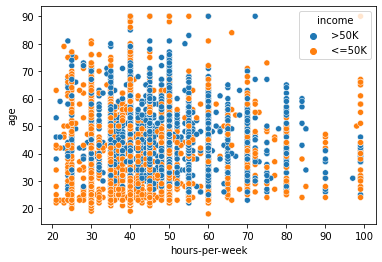

In [14]:
sns.scatterplot(data=df, x="hours-per-week", y="age", hue="income")
plt.show()

It's difficult to draw very concrete conclusions from this initial scatterplot. We can start to see traces of a trend as we focus specifically on the bottom of the chart. There is a great cluster of orange datapoints below 30 years old and up to about 50 hours a week, all indicating persons who make less than $50,000 in a year. 

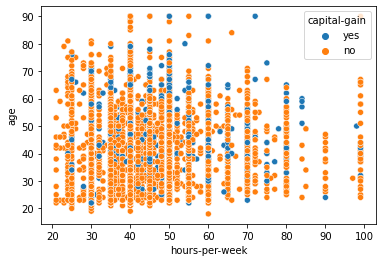

In [15]:
sns.scatterplot(data=df, x="hours-per-week", y="age", hue="capital-gain")
plt.show()

Once again, the indicators of capital gain seem to gain frequency as you move up in the chart, but it is tough to tell for sure. At first glance, these two charts support my hypothesis to some extent, but I'd like something more definitive.

# Step 3: Machine Learning

Here, I am going to use a Gradient Boosting model to predict whether a person will make more than $50,000 based on their age and how many hours a week they work.

In [16]:
X = df[['age', 'hours-per-week', 'capital-gain']]
y = df['income'][df['age']< 35].values

X = pd.get_dummies(X)

In [17]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X[X['age'] < 35], y, test_size = .25, random_state = 246)

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=200, learning_rate = learning_rate, max_features=2, random_state = 246)
    gb.fit(X1_train, y1_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X1_train, y1_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X1_test, y1_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.772
Accuracy score (validation): 0.760

Learning rate:  0.1
Accuracy score (training): 0.775
Accuracy score (validation): 0.765

Learning rate:  0.25
Accuracy score (training): 0.782
Accuracy score (validation): 0.744

Learning rate:  0.5
Accuracy score (training): 0.784
Accuracy score (validation): 0.751

Learning rate:  0.75
Accuracy score (training): 0.785
Accuracy score (validation): 0.752

Learning rate:  1
Accuracy score (training): 0.786
Accuracy score (validation): 0.756

Learning rate:  1.25
Accuracy score (training): 0.782
Accuracy score (validation): 0.748



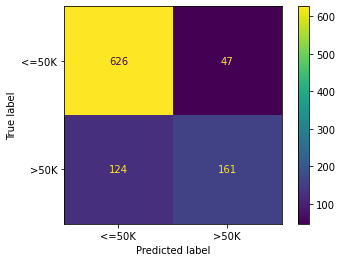

In [19]:
from sklearn.metrics import plot_confusion_matrix
gb = GradientBoostingClassifier(n_estimators=200, learning_rate = 1, max_features=2, random_state = 246)
gb.fit(X1_test, y1_test)
y1_pred = gb.predict(X1_test)

plot_confusion_matrix(gb, X1_test, y1_test)
plt.show()

Around 20.5% of correctly predicted people (161/787) under the age of 35 are making over $50,000. Now lets see how it looks for people above the age of 35. 

In [20]:
y2 = df['income'][df['age']> 35].values

X2_train, X2_test, y2_train, y2_test = train_test_split(X[X['age'] > 35], y2, test_size = .25, random_state = 246)

In [21]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=200, learning_rate = learning_rate, max_features=2, random_state = 246)
    gb.fit(X2_train, y2_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X2_train, y2_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X2_test, y2_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.669
Accuracy score (validation): 0.639

Learning rate:  0.1
Accuracy score (training): 0.674
Accuracy score (validation): 0.641

Learning rate:  0.25
Accuracy score (training): 0.681
Accuracy score (validation): 0.636

Learning rate:  0.5
Accuracy score (training): 0.685
Accuracy score (validation): 0.633

Learning rate:  0.75
Accuracy score (training): 0.689
Accuracy score (validation): 0.629

Learning rate:  1
Accuracy score (training): 0.691
Accuracy score (validation): 0.619

Learning rate:  1.25
Accuracy score (training): 0.691
Accuracy score (validation): 0.603



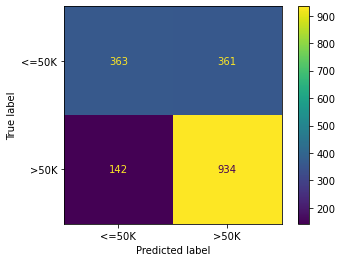

In [23]:
from sklearn.metrics import plot_confusion_matrix
gb = GradientBoostingClassifier(n_estimators=200, learning_rate = .5, max_features=2, random_state = 246)
gb.fit(X2_test, y2_test)
y2_pred = gb.predict(X2_test)

plot_confusion_matrix(gb, X2_test, y2_test)
plt.show()

Interestingly, this predictor is much less accurate than the one for younger people. We know that people who have been working for longer are more likely to get a better paying position, so that could be a large contributing factor. Simultaneously, just above 72% (934/1297) of correctly predicted people had an income of above $50,000

# Step 4: Analysis

Knowing that less and less young people are buying houses in the United States, it is apparent that there is a wage gap affecting one's ability to own a home. I think that is because of a wage gap in our economic system that very heavily favors seniority over work ethic. we can clearly see that a person over 35 has a great advantage in homebuying since they will very frequently make more money. A younger person must work much harder in this currect economy in order to make above $50,000 a year, nevermind own a home. It's just not fair to those people to call them lazy if they can't afford a house in this market. 